## Importing Libraries
**Importing the libraries needed to build this program**

In [1]:
ls

 Volume in drive C is Windows
 Volume Serial Number is E2EC-E904

 Directory of c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN

03/05/2025  02:50 CH    <DIR>          .
03/05/2025  08:32 SA    <DIR>          ..
03/05/2025  10:27 SA    <DIR>          Data
02/05/2025  04:04 CH             1.138 labels.csv
03/05/2025  08:32 SA             1.096 LICENSE
03/05/2025  08:37 SA             2.276 main.py
03/05/2025  08:07 SA             1.033 Meta.csv
03/05/2025  09:38 SA         1.429.992 model.h5
03/05/2025  09:09 SA        18.785.573 model.keras
03/05/2025  08:32 SA             4.382 README.md
03/05/2025  08:58 SA                98 requirements.txt
03/05/2025  08:07 SA           427.897 Test.csv
03/05/2025  08:46 SA    <DIR>          traffic_Data
03/05/2025  08:13 SA         1.940.896 Train.csv
03/05/2025  09:39 SA           155.615 Training.ipynb
03/05/2025  08:41 SA    <DIR>          venv
              11 File(s)     22.749.996 bytes
               5 Dir(s)  29.351.432.192 

In [2]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D


# Function to load and preprocess images
def load_images_from_directory(path, image_size=(30, 30)):
    images = os.listdir(path)
    data = []
    labels = []
    class_id = int(os.path.basename(path))  # Sửa dòng này

    for image_filename in images:
        try:
            image = Image.open(os.path.join(path, image_filename))
            image = image.resize(image_size)
            image = np.array(image)
            data.append(image)
            labels.append(class_id)
        except:
            print(f"Error loading image: {os.path.join(path, image_filename)}")

    return data, labels


# Retrieving the images and their labels
data = []
labels = []
num_classes = 43
current_path = os.getcwd()

for class_id in range(num_classes):
    path = os.path.join(current_path, 'data/Train', str(class_id))
    class_data, class_labels = load_images_from_directory(path)
    data.extend(class_data)
    labels.extend(class_labels)

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

# Replace the Flatten layer with GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())

# Optionally, you can add more Dense layers with BatchNormalization and Dropout
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

# Make sure num_classes is defined properly for your specific problem
model.add(Dense(num_classes, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
history = model.fit(X_train, y_train_one_hot, batch_size=32, epochs=epochs, validation_data=(X_test, y_test_one_hot))
#model.save("model.h5")

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


c:\Users\T\Desktop\Al_Project\Traffic-Sign-Detection-Using-CNN\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3479 - loss: 2.5985 - val_accuracy: 0.9148 - val_loss: 0.3170
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8941 - loss: 0.3534 - val_accuracy: 0.9773 - val_loss: 0.0796
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9480 - loss: 0.1753 - val_accuracy: 0.9690 - val_loss: 0.1101
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9604 - loss: 0.1299 - val_accuracy: 0.9841 - val_loss: 0.0565
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9623 - loss: 0.1207 - val_accuracy: 0.9206 - val_loss: 0.3373
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9719 - loss: 0.0975 - val_accuracy: 0.9894 - val_loss: 0.0322
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9754 - loss: 0.0869 - val_accuracy: 0.9920 - val_loss: 0.0299
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9744 - loss: 0.0860 - 

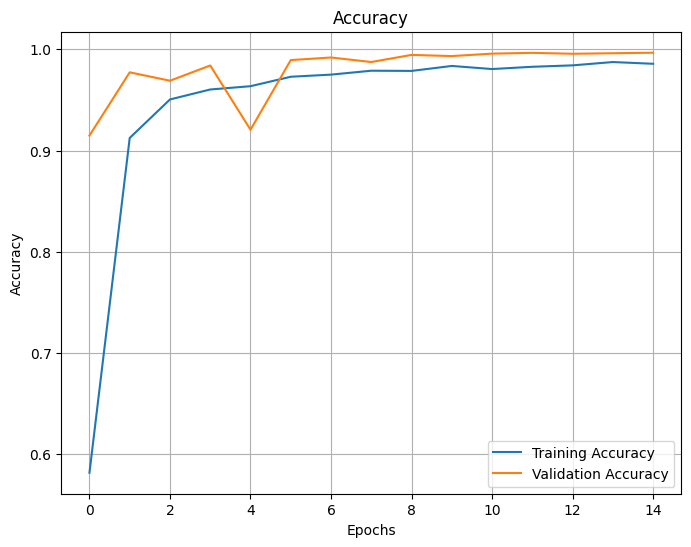

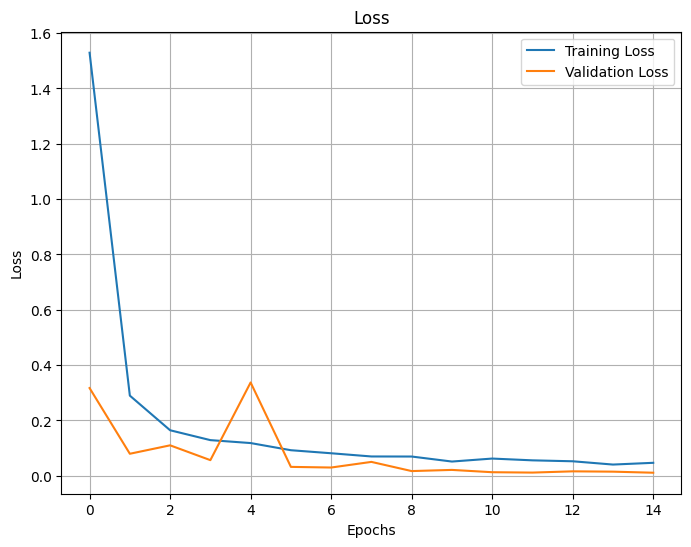

In [3]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting graphs for accuracy and loss
plot_accuracy(history)
plot_loss(history)


In [4]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score
import pandas as pd

y_test = pd.read_csv('data/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]

for img in imgs:
    image = Image.open("data/"+img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)

# Make predictions on the test data
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

model.save('model.h5')


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


0.9600950118764846
